# Intermediate Python

## Iterators

An iterator is an object that enables a programmer to traverse a data container (similar to a database cursor).


In [1]:
for value in [1,3,2]:
    print(value)

1
3
2


An iterator can be useful in some situations, namely:

* To process data structures with no or slow random access, like trees or on-disk data.

* Iterators can provide a consistent way to iterate on data structures of all kinds, and therefore make the code more readable, reusable, and less sensitive to a change in the data structure.


A typical use of an iterator is to create lists using the `comprehension list` constructor:

In [2]:
[i for i in range(10) if i % 3]

[1, 2, 4, 5, 7, 8]

In [3]:
import numpy as np
np.array([i for i in range(10) if i % 3], dtype='int32')

array([1, 2, 4, 5, 7, 8], dtype=int32)

## Generators

Iterators can be used to create other structures without an intermediate container.  Let's see how we can use a generator (an implementation of an iterator) for doing this:

In [4]:
(i for i in range(10) if i % 3)

<generator object <genexpr> at 0x109c78a98>

In [5]:
np.fromiter((i for i in range(10) if i % 3), dtype='int32')

array([1, 2, 4, 5, 7, 8], dtype=int32)

Note how in this case we don't need an intermediate list so as to create a NumPy array out of the iterator.

### Example

In [6]:
# Generate a range of floating point numbers 
def frange(fmin, fmax, divisions):
    delta = (fmax - fmin) / divisions
    x = fmin
    for i in range(divisions):
        yield x
        x += delta

In [7]:
[f for f in frange(0,5,10)]   # why the result?

[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

In [8]:
[f for f in frange(0.,5,10)]  # the intended outcome

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

Generators are typically faster than comprehension lists (and takes less memory!):

In [9]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [9] used 0.016 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 39.453 MiB


In [19]:
arr2 = np.fromiter((f for f in frange(0.,5.,int(1e6))), dtype='f8')

In [19] used -8.504 MiB RAM in 0.269s, peaked 0.000 MiB above current, total RAM usage 53.906 MiB


In [20]:
arr1 = np.fromiter([f for f in frange(0.,5.,int(1e6))], dtype='f8')

In [20] used 9.391 MiB RAM in 0.287s, peaked 13.215 MiB above current, total RAM usage 63.297 MiB


Although the fastest is always use embedded C code (if you can!):

In [21]:
arr3 = np.linspace(0, 5, 1e6, endpoint=False)

In [21] used 13.953 MiB RAM in 0.015s, peaked 0.000 MiB above current, total RAM usage 77.250 MiB


In [22]:
np.allclose(arr1, arr2), np.allclose(arr1, arr3)

(True, True)

In [22] used 14.047 MiB RAM in 0.074s, peaked 0.000 MiB above current, total RAM usage 91.297 MiB


Generators are also useful in reductions:

In [23]:
sum([f for f in frange(0.,5.,int(1e6))])

2499997.4999724193

In [23] used -23.656 MiB RAM in 0.230s, peaked 35.730 MiB above current, total RAM usage 67.641 MiB


In [24]:
sum((f for f in frange(0.,5.,int(1e6))))

2499997.4999724193

In [24] used -0.250 MiB RAM in 0.230s, peaked 0.000 MiB above current, total RAM usage 67.391 MiB


In [26]:
mw.stop_watching_memory()

### Exercise

Study the generator below and suggest an efficient way to render the image with NumPy/matplotlib.

In [52]:
# Make a plot of the mandelbrot set

# Test a given x,y coordinate to see if it's a member of the set
def in_mandelbrot(x0, y0, n):
    x = 0
    y = 0
    while n > 0:
        xtemp = x * x - y * y + x0
        y = 2 * x * y + y0
        x = xtemp
        n -= 1
        if x * x + y * y > 4: return False
    return True

# Generate a range of floating point numbers 
def frange(xmin,xmax,ymin, ymax, xdivisions, ydivisions):
    deltax = (xmax - xmin)/xdivisions
    deltay = (ymax - ymin)/ydivisions
    x = xmin
    for i in range(xdivisions):
        y = ymin
        for j in range(ydivisions):
            yield x,y
            y += deltay
        x += deltax
        

# Generate all of the pixels of the mandelbrot set.  The output of
# this function is a sequence of rows.  Each row is a sequence of
# True/False values indicating whether or not a point is a member
# of the set or not. Note: This is using generators and generator
# expressions to produce all of the pixels without ever allocating
# a huge array of pixels in memory. 
def generate_mandel(xmin=-2.0, ymin=-1.5, width=3.0, height=3.0, pixels=128, n=400):
    for x,y in frange(xmin, xmin+width, ymin, ymin + height, pixels, pixels):
        yield in_mandelbrot(x, y, n)


### Solution

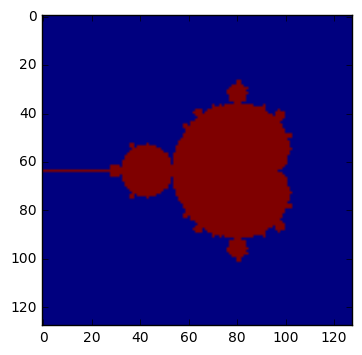

In [59]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

a = np.fromiter( (i for i in generate_mandel()), dtype=bool).reshape(128,128).T
plt.imshow(a)
    

## Context managers

Python’s with statement was first introduced five years ago, in Python 2.5. It’s handy when you have two related operations which you’d like to execute as a pair, with a block of code in between. The classic example is opening a file, manipulating the file, then closing it:

In [60]:
# The context manager is here:
with open('output.txt', 'w') as f:
    f.write('Hi there!')
! cat 'output.txt'

Hi there!

Note how the `f` handler is opened only within the scope of the context manager.  After that is closed:

In [61]:
f

<_io.TextIOWrapper name='output.txt' mode='w' encoding='UTF-8'>

## Decorators

*Using* decorators is easy! ...but writing them can be complicated.  I'll concentrate on usage, but the concept is powerful, so you may want to get more info about writing them.

### Example

In [62]:
import collections
import functools

class memoized(object):
   '''Decorator. Caches a function's return value each time it is called.
   
   If called later with the same arguments, the cached value is returned
   (not reevaluated).
   '''
   
   def __init__(self, func):
      self.func = func
      self.cache = {}

   def __call__(self, *args):
      if not isinstance(args, collections.Hashable):
         # uncacheable. a list, for instance.
         # better to not cache than blow up.
         return self.func(*args)
      if args in self.cache:
         return self.cache[args]
      else:
         value = self.func(*args)
         self.cache[args] = value
         return value

   def __repr__(self):
      '''Return the function's docstring.'''
      return self.func.__doc__

   def __get__(self, obj, objtype):
      '''Support instance methods.'''
      return functools.partial(self.__call__, obj)

@memoized
def fibonacci(n):
   "Return the nth fibonacci number."
   if n in (0, 1):
      return n
   return fibonacci(n-1) + fibonacci(n-2)

In [63]:
print(fibonacci(12))

144


In [64]:
%time fibonacci(130)

CPU times: user 867 µs, sys: 208 µs, total: 1.07 ms
Wall time: 1.1 ms


659034621587630041982498215

In [65]:
%time fibonacci(140)

CPU times: user 85 µs, sys: 1e+03 ns, total: 86 µs
Wall time: 88.9 µs


81055900096023504197206408605

### Exercise

Decorate the `in_mandelbrot()` function above with the @numba.autojit decorator (`import numba` first) and repeat the computations.  How much they accelerate?

## Packaging for distribution

Packaging is normally made through [distutils](http://docs.python.org/2/distutils/introduction.html) and is a matter of building a 'setup.py' file.  For example, let's suppose that we want to pack or new mandebrot module to send it to a friend:

In [67]:
%%file mandelbrot.py

# Make a plot of the mandelbrot set
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm

# Test a given x,y coordinate to see if it's a member of the set
def in_mandelbrot(x0, y0, n):
    x = 0
    y = 0
    while n > 0:
        xtemp = x * x - y * y + x0
        y = 2 * x * y + y0
        x = xtemp
        n -= 1
        if x * x + y * y > 4:
            return False
    return True

# Generate a range of floating point numbers 
def frange(fmin,fmax,divisions):
    delta = (fmax - fmin)/divisions
    x = fmin
    for i in range(divisions):
        yield x
        x += delta

# Generate all of the pixels of the mandelbrot set.  The output of
# this function is a sequence of rows.  Each row is a sequence of
# True/False values indicating whether or not a point is a member
# of the set or not. Note: This is using generators and generator
# expressions to produce all of the pixels without ever allocating
# a huge array of pixels in memory. 
def generate_mandel(xmin=-2.0, ymin=-1.5, width=3.0, height=3.0, pixels=128, n=400):
    for y in frange(ymin, ymin + height, pixels):
        for x in frange(xmin, xmin + width, pixels):
            yield in_mandelbrot(x, y, n)

if __name__ == "__main__":
    import sys
    if len(sys.argv) > 1:
        npixels = int(sys.argv[1])
    else:
        npixels = 128
    img = generate_mandel(pixels=npixels)
    im = np.fromiter(img, dtype=bool).reshape(npixels, npixels)
    plt.imshow(im, cmap=cm.gray_r)
    plt.show()

Writing mandelbrot.py


Now, we can build a minimalistic setup.py for packaging it:

In [68]:
%%file setup.py

from distutils.core import setup
setup(name='mymandel',
      version='1.0',
      py_modules=['mandelbrot'],
      )

Writing setup.py


And we can create a tarball easily with:

In [39]:
!python setup.py sdist

running sdist
running check




writing manifest file 'MANIFEST'
creating mymandel-1.0
making hard links in mymandel-1.0...
hard linking mandelbrot.py -> mymandel-1.0
hard linking setup.py -> mymandel-1.0
Creating tar archive
removing 'mymandel-1.0' (and everything under it)


In [40]:
!ls -l dist  # this is put in the 'dist/' directory

total 8
-rw-r--r--  1 faltet  staff  1110 Oct 18 08:29 mymandel-1.0.tar.gz


Then, your friend on has to unpack the tarball and install it in his own system with:

In [41]:
# Just don't run the line below so as to not mess your environment...
#!python setup.py install

### Exercise

Remember the warnings during the `sdist` task above?  Try to get rid of them.

Hint: have a look at the [manual of distutils](http://docs.python.org/2/distutils/introduction.html).